In [9]:
!pip install stable-baselines==2.9.0

     |████████████████████████████████| 235kB 5.0MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [1]:
import numpy as np

import datetime
import time
from collections import deque

import torch as T
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.distributions import Categorical
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt
import seaborn as sns

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
NENV = 8
ROLLOUT_LENGTH = 128
LATENT_SIZE = 64
MB_SPLIT = 4
MB_EPOCHS = 4
TOTAL_TIMESTEPS = 5e6
GAMMA = 0.99
CLIP = 0.2
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
SEED = 420 
set_global_seeds(SEED)
sns.set()  # make it pretty

# Environment

In [3]:
env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
in_dim=(in_dim[2],in_dim[0],in_dim[1])  # torch ordering
num_actions = env.action_space.n

print('Observation shape: ', in_dim)
print('Number of actions: ', num_actions)

Observation shape:  (4, 84, 84)
Number of actions:  4


# CNNs

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
def ConvReLU_down(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True),
    )

def ConvReLU_up(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size

        self.down_1 = ConvReLU_down(self.c, 64, 8, 4)
        self.down_2 = ConvReLU_down(64, 32, 4, 2)
        self.down_3 = ConvReLU_down(32, 16, 4, 1)

        encoder_conv = nn.Sequential(self.down_1, self.down_2, self.down_3)
        self.conv_x, self.conv_f = conv_size(encoder_conv, input_shape)

        self.down_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.up_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.up_3 = ConvReLU_up(16*2+self.num_actions, 32, 4, 1)
        self.up_2 = ConvReLU_up(32*2, 64, 4, 2)
        self.up_1 = nn.ConvTranspose2d(64*2, self.c, 8, 4)

    def encode(self, x):
        """ *represent* the environment in latent space"""
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.down_3(x)
        x = self.down_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions):
        _,_,ch,cw = self.conv_x
        cn = len(actions)
        z = np.zeros((len(actions), self.num_actions, ch, cw), dtype=np.float32)
        for i in range(cn):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions=None):
        """ actions is a list of ints describing the actions taken """
        d1 = self.down_1(x)
        d2 = self.down_2(d1)
        d3 = self.down_3(d2)
        latent = self.down_linear(d3)
        
        x = self.up_linear(latent)        
        x = x.view(self.conv_x)
        # cat contractive path
        x = T.cat((x, d3), dim=1)
        # add information about which action we took
        if actions is None:  # for torchsummary
            z_action = self.one_hot_3d_action([0]*x.size(0))
        else:
            z_action = self.one_hot_3d_action(actions)
        x = T.cat((x, z_action), dim=1)

        x = self.up_3(x)
        x = T.cat((x, d2), dim=1)
        x = self.up_2(x)
        x = T.cat((x, d1), dim=1)
        x = self.up_1(x)

        return x, latent

In [0]:
class ACTOR(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x)

class CRITIC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.critic(x)

# Rollout handling

In [0]:
class Rollouts:

    def __init__(self):
        self.empty_memory()

    def store_transition(self, ob, logp, action, reward, value, done, info):
        self.obs.append(ob)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        for i in info:
            if i.get('episode'): 
                self.infos['l'].append(i['episode']['l'])
                self.infos['r'].append(i['episode']['r'])

    def empty_memory(self):
        self.obs      = []
        self.obs_d1   = []  # t+1
        self.obs_d2   = []  # t+2
        self.logps    = []
        self.actions  = []
        self.rewards  = []
        self.values   = []
        self.dones    = []
        self.infos   = {'l':[], 'r':[]}

    def preprocess_obs(self, arr):
        """ Normalize and permute array :param arr: to make it Torch compatible """
        return np.moveaxis(arr.astype(np.float32) / 255., -1, 1)

    def flatten(self, x, flat_n, to_tensor=True):
        """ flatten x *in place* to (flat_n, ...)
            :param to_tensor: if true, x is cast to a torch tenor """
        x = np.asarray(x, np.float32).reshape((flat_n,)+x[0].shape[1:])
        if to_tensor: 
            return T.from_numpy(x).to(DEVICE)
        return x

    def flatten_rollout(self):
        """ flatten trajectory buffers to (NENV*ROLLOUT_LENGTH-1, ...)"""
        N = (ROLLOUT_LENGTH-1)*NENV
        self.obs     = self.flatten(self.obs, N)
        self.obs_d1  = self.flatten(self.obs_d1, N)
        self.obs_d2  = self.flatten(self.obs_d2, N)
        self.logps   = self.flatten(self.logps, N)
        self.actions = self.flatten(self.actions, N)
        self.rewards = self.flatten(self.rewards, N)
        self.values  = self.flatten(self.values, N)


    def generator(self, random=False):

        ob = self.preprocess_obs(env.reset())  # initial observation
        rollout_num = 0

        while True:
            rollout_num += 1
            
            with T.no_grad():
                tob = T.from_numpy(ob).to(DEVICE)
                z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                z_join = T.cat((z1,z2), dim=1)   # joint latent repr

                pi     = actor(z_join)           # action scores
                v      = critic(z_join)          # value
                dist   = Categorical(logits=pi)  # to multinomial (discreet)
                action = dist.sample()
                print(action.size())
                if random: action = T.randint_like(action, 0, num_actions)
                log_pi = dist.log_prob(action).cpu().numpy()
                action = action.cpu().numpy()
                v = v.cpu().numpy()[:, 0]
            
            new_ob, reward, done, info = env.step(action)
            self.store_transition(ob, log_pi, action, reward, v, done, info)
            ob = self.preprocess_obs(new_ob)

            if rollout_num % ROLLOUT_LENGTH == 0:
                # bootstrap reward from critic predicted value function
                # note that v is V(S_{t+1}) - TD(1) (one step returns)
                with T.no_grad():
                    tob = T.from_numpy(ob).to(DEVICE)
                    z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                    z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                    z_join = T.cat((z1,z2), dim=1)   # joint latent repr
                    flags = 1 - done   # should we bootstrap or not?
                    v = critic(z_join)  # value of next state TD(1)
                    v = v.cpu().numpy()[:, 0] * flags

                # reward discounting / creit assignment
                self.rewards[-1] += GAMMA * v
                for i in reversed(range(ROLLOUT_LENGTH - 1)):
                    flags = 1 - self.dones[i]
                    self.rewards[i] += GAMMA * self.rewards[i+1] * flags

                self.obs_d1 = self.obs[1:]         # for ae_delta_1
                self.obs_d2 = self.obs[2:] + [ob]  # for ae_delta_2
                del self.obs[-1]
                del self.logps[-1]
                del self.actions[-1]
                del self.values[-1]
                del self.rewards[-1]

                # reshape and cast to torch tensors (rollouts)
                self.flatten_rollout()
                yield self.obs, self.obs_d1, self.obs_d2, self.logps, self.actions, self.values, self.rewards, self.infos
                self.empty_memory()

# Train

In [8]:
# this autoencoder predicts S_{t+1}.
ae_delta_1 = UNet(in_dim, num_actions, LATENT_SIZE).to(DEVICE)
ae_optim_1 = Adam(ae_delta_1.parameters(), 7e-4, eps=1e-5)
T.save(ae_delta_1, 'clone.t')

# this autoencoder predicts S_{t+2}. 
# cloned so latent dynamics are similar.
ae_delta_2 = T.load('clone.t').to(DEVICE)
ae_optim_2 = Adam(ae_delta_2.parameters(), 7e-4, eps=1e-5)

# this is our actor + critic
# input is both latent vectors of above autoencoders.
actor = ACTOR(LATENT_SIZE*2, num_actions).to(DEVICE)
actor_optim = Adam(actor.parameters(), 7e-4, eps=1e-5)

critic = CRITIC(LATENT_SIZE*2, num_actions).to(DEVICE)
critic_optim = Adam(critic.parameters(), 7e-4, eps=1e-5)

summary(ae_delta_1, input_size=in_dim, batch_size=NENV*ROLLOUT_LENGTH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 64, 20, 20]          16,448
              ReLU-2         [1024, 64, 20, 20]               0
            Conv2d-3           [1024, 32, 9, 9]          32,800
              ReLU-4           [1024, 32, 9, 9]               0
            Conv2d-5           [1024, 16, 6, 6]           8,208
              ReLU-6           [1024, 16, 6, 6]               0
           Flatten-7                [1024, 576]               0
            Linear-8                 [1024, 64]          36,928
            Linear-9                [1024, 576]          37,440
             ReLU-10                [1024, 576]               0
  ConvTranspose2d-11           [1024, 32, 9, 9]          18,464
             ReLU-12           [1024, 32, 9, 9]               0
  ConvTranspose2d-13         [1024, 64, 20, 20]          65,600
             ReLU-14         [1024, 64,

In [0]:
NUM_UPDATES = 1000

MB_LEN      = int(NENV*(ROLLOUT_LENGTH-1))
SPLIT_LEN   = int(MB_LEN//MB_SPLIT)
NUM_UPDATES = int(TOTAL_TIMESTEPS//MB_LEN)

rgen = Rollouts().generator(random=True)

actor_scheduler  = LambdaLR(actor_optim, lambda i: 1 - (i / NUM_UPDATES))
critic_scheduler  = LambdaLR(critic_optim, lambda i: 1 - (i / NUM_UPDATES))
ae_1_scheduler = LambdaLR(ae_optim_1, lambda i: 1 - (i / NUM_UPDATES))
ae_2_scheduler = LambdaLR(ae_optim_2, lambda i: 1 - (i / NUM_UPDATES))

In [13]:
FR = ROLLOUT_LENGTH*NENV

loss_history_ae_1 = []
loss_history_ae_2 = []
frames_loss_history_ae_1 = []
frames_loss_history_ae_2 = []

# Testing AE / pretraining
for ii in range(NUM_UPDATES):
    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)
    for jj in range(100):
        pred_ae_1, z1 = ae_delta_1(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_1 = citerion(pred_ae_1, obs_d1)
        ae_optim_1.zero_grad()
        loss_ae_1.backward()
        nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
        ae_optim_1.step()

        pred_ae_2, z2 = ae_delta_2(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_2 = citerion(pred_ae_2, obs_d2)
        ae_optim_2.zero_grad()
        loss_ae_2.backward()
        nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
        ae_optim_2.step()

        frames = (ii*100*FR) + (jj*FR)
        loss_history_ae_1.append(loss_ae_1.item())
        frames_loss_history_ae_1.append((frames, loss_ae_1.item()))
        loss_history_ae_2.append(loss_ae_2.item())
        frames_loss_history_ae_2.append((frames, loss_ae_2.item()))
        
    print(f'Batch {ii}, loss_ae_1 {loss_ae_1}, loss_ae_2 {loss_ae_2}')
    ae_1_scheduler.step(ii)
    ae_2_scheduler.step(ii)

    if ii % 5 == 0:
        print('OBS:')
        plt.imshow(obs.cpu().numpy()[500][0])
        plt.show()
        print('TARGET D1:')
        plt.imshow(obs_d1.cpu().numpy()[500][0])
        plt.show()
        print('PRED D1:')
        plt.imshow(pred_ae_1.detach().cpu().numpy()[500][0])
        plt.show()
        print('TARGET D2:')
        plt.imshow(obs_d2.cpu().numpy()[500][0])
        plt.show()
        print('PRED D2:')
        plt.imshow(pred_ae_2.detach().cpu().numpy()[500][0])
        plt.show()

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Si

KeyboardInterrupt: ignored

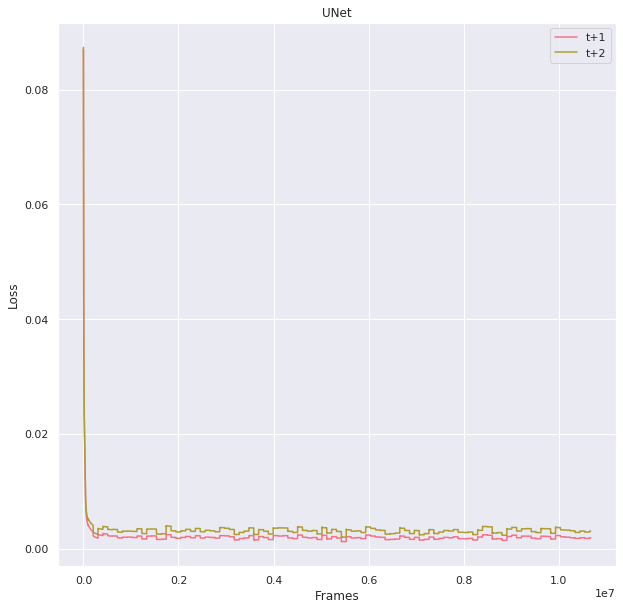

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Frames')
ax.set_ylabel('Loss')
ax.set_title('UNet')
clrs = sns.color_palette("husl", 5)

ax.plot(
    *zip(*frames_loss_history_ae_1),
    label='t+1', 
    c=clrs[0]
)
ax.plot(
    *zip(*frames_loss_history_ae_2),
    label='t+2', 
    c=clrs[1]
)

ax.legend(loc='upper right')

In [0]:
T.save(ae_delta_1.state_dict(), 'ae1-unet-breakout.torch')
T.save(ae_delta_2.state_dict(), 'ae2-unet-breakout.torch')

In [0]:
from google.colab import files

files.download('ae1-unet-breakout.torch')
files.download('ae2-unet-breakout.torch')

In [0]:
import gym

e2 = gym.make(ENV_NAME)
e2.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

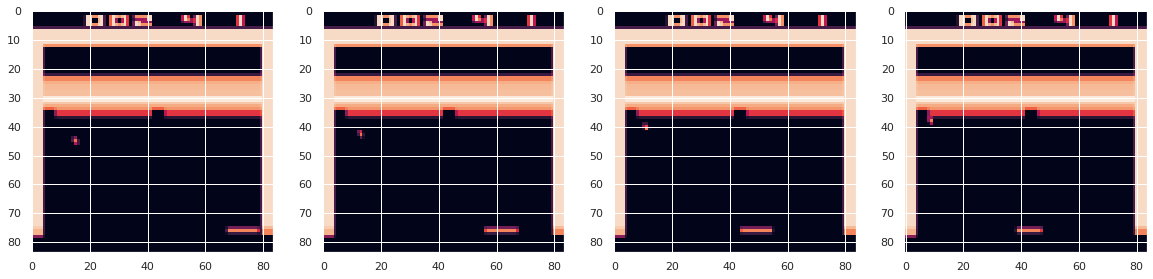

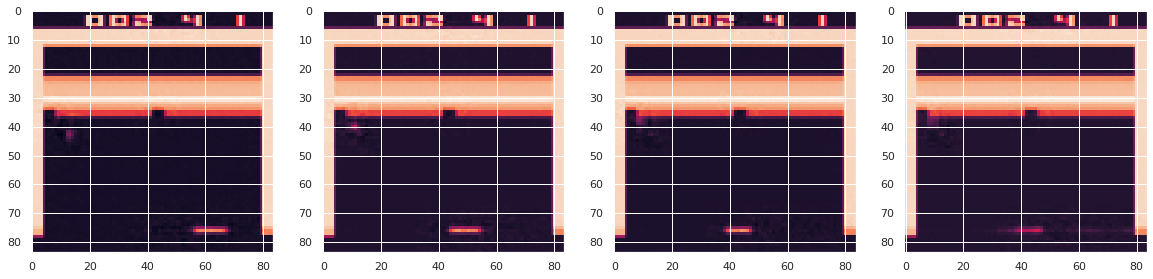

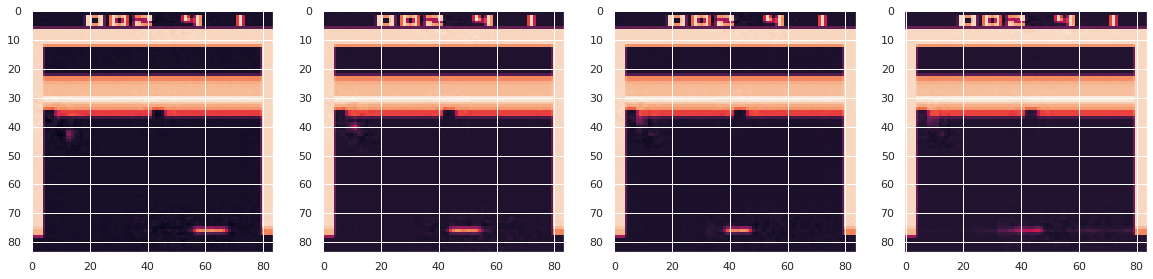

Should have left bais


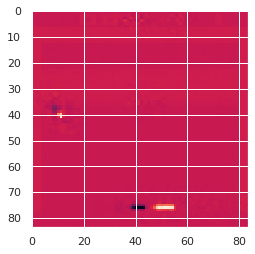

Should have right bais


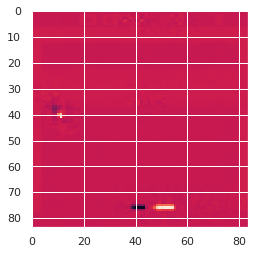

In [0]:
# Lets see whether our model has learned a self model

test_ob = obs[750]

fig, axs = plt.subplots(1, 4, figsize=(20,20))
im_ob = test_ob.cpu().numpy()
[a.imshow(im_ob[i]) for i, a in enumerate(axs)]
plt.show()

# # the paddle should stay stationary after taking action 0
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [0])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# # the paddle should stay stationary after taking action 1
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [1])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# the paddle should be a bit to the right after taking action 2
pred_tb, z_tb = ae_delta_1(test_ob.unsqueeze(0), [2])
im_tb = pred_tb.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_tb[i]) for i, a in enumerate(axs)]
plt.show()

# the paddle should be a bit to the left after taking action 3
pred_ta, z_ta = ae_delta_1(test_ob.unsqueeze(0), [3])
im_ta = pred_ta.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_ta[i]) for i, a in enumerate(axs)]
plt.show()


print('Should have left bais')
plt.imshow((im_ob-im_ta)[2])
plt.show()

print('Should have right bais')
plt.imshow((im_ob-im_tb)[2])
plt.show()


In [0]:
# it hasnt.

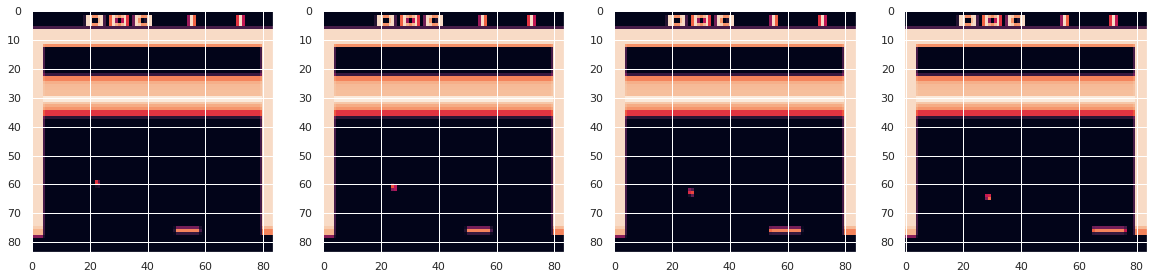

In [0]:
obz,_,_,_ = env.step([2]*8)
im_ob = obz[4]/255.

fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_ob[:,:,i]) for i, a in enumerate(axs)]
plt.show()